# Prepoznavanje facijalnih ekspresija (Facial expression recognition)

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pytorchtools import EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Skup podataka (Dataset)

Izabrani skup podataka za obradu je skup facijalnih ekspresija pod nazivom **FER2013**.

Podaci su javno dostupni i preuzeti sa web stranice *Kaggle*.

Cilj obrade podataka je obučavanje modela za klasifikaciju jedne facijalne ekspresije prikazane na slici. 

Skup podataka sadrži skoro od 36.000 slika, koje predstavljaju 7 klasa facijalnih ekspresija.

In [2]:
class FacialExpressionDataset(Dataset):
    def __init__(self, path, type, transform):
        super().__init__()

        self.features = []
        self.labels = []

        self.type = type
        self.transform = transform
        self.label_encoder = LabelBinarizer()
        self._read(path)

    def _read(self, path):
        data = pd.read_csv(path)
        for index, row in data.iterrows():
            if self.type == row['Usage']:
                self.features.append(self._load_image(row['pixels']))
                self.labels.append(row['emotion'])
        self.labels = self.label_encoder.fit_transform(self.labels).astype(np.float32)

    def _load_image(self, pixels):
        pixels = np.array(list(map(int, pixels.split())), dtype=np.float32)/255
        return self.transform(pixels.reshape((48, 48, 1)))

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

### Pripremna obrada podataka

Svaka slika je konvertovana u tenzor.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset_path = "dataset/fer2013.csv"

train_dataset = FacialExpressionDataset(dataset_path, "Training", transform)
valid_dataset = FacialExpressionDataset(dataset_path, "PublicTest", transform)
test_dataset = FacialExpressionDataset(dataset_path, "PrivateTest", transform)

### Informacije o broju uzoraka i klasa

Podaci su već podeljeni na trening, validacioni i test skup, a njihov odnos je takav da je 80% podataka za trening, a po 10% za validaciju i testiranje.

In [4]:
classes = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Suprise', 
    6: 'Neutral'
}

In [5]:
total_examples = len(train_dataset) + len(valid_dataset) + len(test_dataset)

print(f"Ukupan broj uzoraka = {total_examples}")
print(f"Broj uzoraka za trening = {len(train_dataset)} ({len(train_dataset)/total_examples*100:.2f}%)")
print(f"Broj uzoraka za validaciju = {len(valid_dataset)} ({len(valid_dataset)/total_examples*100:.2f}%)")
print(f"Broj uzoraka za testiranje = {len(test_dataset)} ({len(test_dataset)/total_examples*100:.2f}%)")
print(f"Broj klasa = {len(classes)}")

Ukupan broj uzoraka = 35887
Broj uzoraka za trening = 28709 (80.00%)
Broj uzoraka za validaciju = 3589 (10.00%)
Broj uzoraka za testiranje = 3589 (10.00%)
Broj klasa = 7


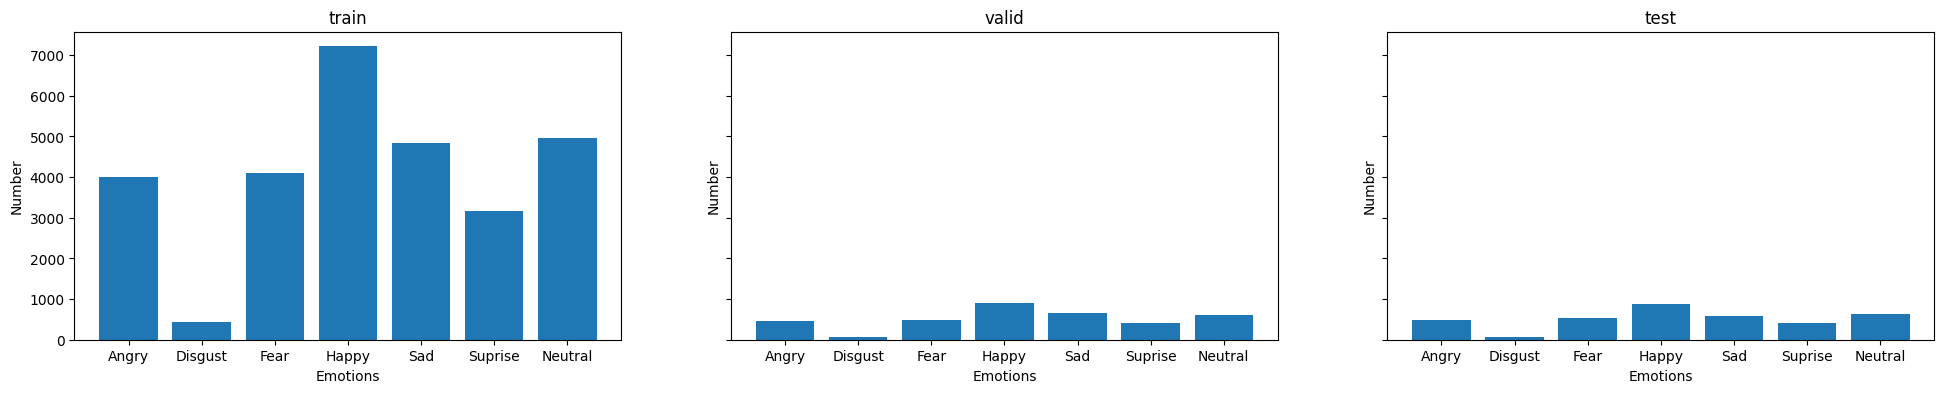

In [6]:
def setup_axe(axe, data, encoder, title):
    display_data = encoder.inverse_transform(data)
    occurrences = [np.count_nonzero(display_data == key) for key in classes.keys()]
    axe.bar(classes.values(), occurrences)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)

fig, axes = plt.subplots(1, 3, figsize=(24,4), sharey=True)
setup_axe(axes[0], train_dataset.labels, train_dataset.label_encoder, 'train')
setup_axe(axes[1], valid_dataset.labels, valid_dataset.label_encoder, 'valid')
setup_axe(axes[2], test_dataset.labels, test_dataset.label_encoder, 'test')

### Nasumični predstavnici svih klasa u skupu podataka

Kao što se može videti iz primera klasa, skup podataka je izazovan iz razloga sto je veliki broj slika mutan, a neke slike su ili previše ili nedovoljno osvetljene.

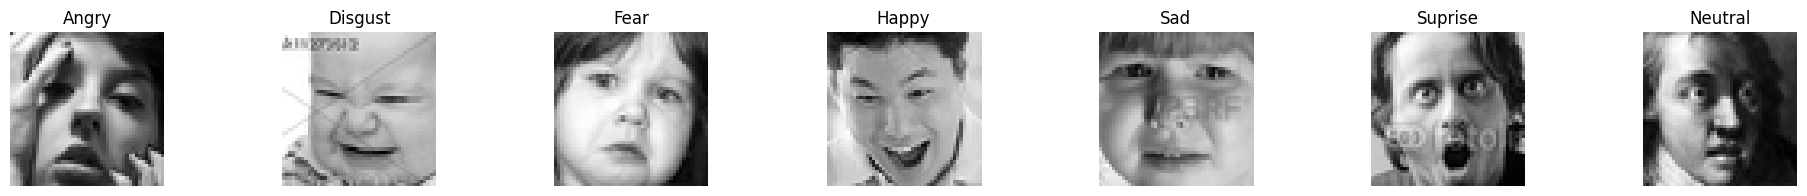

In [7]:
fig, axes = plt.subplots(1, 7, figsize=(24, 2))
display_labels = test_dataset.label_encoder.inverse_transform(test_dataset.labels)

for class_id, class_name in classes.items():
    axe = axes[class_id]
    axe.set_title(class_name)
    axe.set_axis_off()
    i = np.random.choice(np.where(display_labels == class_id)[0])
    image = np.transpose(test_dataset[i][0], (1, 2, 0))
    axe.imshow(image, cmap="gray")

## Određivanje hardvera za računanja

Ukoliko je CUDA dostupan, koristiće se GPU, u suprotnom koristi se CPU.

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

print(f"Hardver koji ce se upotrebljivati = {device}")

def to_device(x, y):
    return x.to(device), y.to(device)

Hardver koji ce se upotrebljivati = cuda


In [9]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [10]:
train_dl = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device) 
valid_dl = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device) 
test_dl = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

## Konvolucijska neuronska mreža (Convolutional Neural Network)

Konvolucijska neuronska mreza (CNN) je vrsta feedforward veštacke neuronske mreže koja se često primenjuje za analizu slika. Arhitektura ove mreže sačinjena iz tri osnovne komponente:

##### 1. Konvolucioni sloj (Convolution Layer)

Konvulacija je matematički operator koji od dve funkcije, $f$ i $g$, proizvodi treću funkciju $f*g$ koja izražava koliko je oblik jedne funkcije modifikovan drugom.

Ovo je najvažniji sloj u okviru konvolucijskih mreža, to jest na njemu je bazirana mreža.

U konvulucionom sloju koristi se kernel, to jest filter, koji izvlači relevantne osobine iz ulaza upotrebom operacije konvulacije. Oni se koriste za izoštravanje slike i zamućenje slika, kao i za detektovanje ivica.

##### 2. Sloj sažimanja (Pooling Layer)

Sloj sažimanja je sloj koji se periodično javlja, a čija je uloga smanjivanje dimenzija slike kako bi se smanjio broj parametara.

Postoje dve opcije koje se mogu izabrati u okviru ovog sloja: sažimanje maksimumom (Max Pooling) i sažimanje pomoću srednje vrednosti (Average Pooling).

##### 3. Potpuno povezan sloj (Fully Connected Layer)

Zbog velikog broj parametra, neuroni u prethodnom delu mreže ne moraju biti potpuno povezani, te se zbog toga u završnim slojevima mreže pojavljuju potpuno povezani slojevi. 

To nije pravilo, ali se u najvećem broju slučajeva realizuje na taj način, jer su dimenzije na ulazu u ovaj sloj znatno manje.

#### Aktivaciona funkcija

Aktivaciona funkcija se koristi za poboljšanje perfomansi mreže; za aktivacionu funkciju ovde je iskorišćena ReLU funkcija koja se veoma cešto koristi za skrivene slojeve u neuronskim mrežama.

In [11]:
class CNN(nn.Module):
    def __init__(self, classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(2304, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.out = nn.Linear(128, classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1, 2304)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return self.out(x)

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model ima {count_parameters(CNN(len(classes)))} parametara koji treba da se treniraju")

Model ima 2494855 parametara koji treba da se treniraju


### Definisanje funkcija za treniranje i testiranje.

U metodi za treniranje koristi se objekat klase EarlyStopping koji će pratiti gubitak validacije.

Ukoliko nakon određene toleranicije ona ne nastavi da se smanjuje - obustaviće treniranje i vratiti model na parametere kada je prvi put dostignuta najmanja grešku kako bi se sprečio overfitting.

In [13]:
def evaluate(model, loss_func, dl):
    loss = 0
    total = 0
    correct = 0

    with torch.no_grad():
        for fv, y in dl:
            yp = model.forward(fv)
            loss += loss_func(yp, y)
            max_index = torch.argmax(yp, dim=1).cpu()
            total += yp.size(0)
            y_transformed = torch.tensor(list(map(lambda y: np.argmax(y), y.cpu().numpy())))
            correct += (y_transformed == max_index).sum().item()

    return loss/len(dl), correct/total

In [14]:
def train(epochs, patience, model, loss_func, optimizer, train_dl, valid_dl):
    train_losses = []
    valid_losses = []

    early_stopping = EarlyStopping(patience=patience, path="models/checkpoint.pth")

    for epoch in range(epochs):
        total_train_loss = 0

        for fv, y in train_dl:
            optimizer.zero_grad()
            yp = model.forward(fv)
            loss = loss_func(yp, y)
            loss.backward()
            total_train_loss += loss
            optimizer.step()
        
        train_loss = total_train_loss / len(train_dl)
        valid_loss, valid_accuracy = evaluate(model, loss_func, valid_dl)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f"[Epoch {epoch+1}/{epochs}] Training loss: {train_loss:.2f}\t"
                f"Validation loss: {valid_loss:.2f}\tValidation accuracy: {valid_accuracy * 100:.2f}%")

        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load("models/checkpoint.pth"))

    return model, train_losses, valid_losses

In [15]:
def test(model, loss_func, test_dl):
    test_loss, test_accuracy = evaluate(model, loss_func, test_dl)
    print(f"Test loss: {test_loss:.2f}\tTest accuracy: {test_accuracy * 100:.2f}%")

### Gubitak unakrsne entropije (Cross-Entropy Loss)

Gubitak unakrsne entropije određuje perfomanse modela za klasifikaciju čiji su izlazi vrednosti verovatnoće između 0 i 1.

Ova vrednost se povećava kada predviđena verovatnoća divergira od stvarne labele.

U slučaju PyTorch biblioteke, klasa CrossEntropyLoss očekuje sirove podatke, to jest ne treba ih propustiti kroz softmax funkciju, jer ona interno primenjuje softmax.

### Upotreba Adam (Adaptive Moment Estimation) algoritma za optimizaciju

Jedan od najpopularnijih i najčešće upotrebljavanih algoritama za mašinsko učenje je upravo SGD, i on ima brojna proširenja i varijacije.

Adam algoritam je proširenje SGD algoritma, to jest kombinacija RMSProp (Root Mean Squared Propagation) i SGD sa momentumom.

U poslednje vreme ovaj algoritam ima veliku primenu u dubokom učenju za kompjutersku viziju i obradu prirodnih jezika.

In [16]:
net = CNN(len(classes)).to(device)
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
epochs = 20
patience = 5

In [17]:
net, train_losses, valid_losses = train(epochs, patience, net, loss_function, optimizer, train_dl, valid_dl)
test(net, loss_function, test_dl)

[Epoch 1/20] Training loss: 1.48	Validation loss: 1.29	Validation accuracy: 50.93%
[Epoch 2/20] Training loss: 1.18	Validation loss: 1.17	Validation accuracy: 55.31%
[Epoch 3/20] Training loss: 1.04	Validation loss: 1.12	Validation accuracy: 58.54%
[Epoch 4/20] Training loss: 0.93	Validation loss: 1.13	Validation accuracy: 58.54%
[Epoch 5/20] Training loss: 0.82	Validation loss: 1.10	Validation accuracy: 60.27%
[Epoch 6/20] Training loss: 0.69	Validation loss: 1.14	Validation accuracy: 61.35%
[Epoch 7/20] Training loss: 0.56	Validation loss: 1.23	Validation accuracy: 61.10%
[Epoch 8/20] Training loss: 0.43	Validation loss: 1.36	Validation accuracy: 60.82%
[Epoch 9/20] Training loss: 0.32	Validation loss: 1.52	Validation accuracy: 60.02%
[Epoch 10/20] Training loss: 0.25	Validation loss: 1.72	Validation accuracy: 59.82%
Early stopping
Test loss: 1.08	Test accuracy: 60.94%


In [18]:
torch.save(net, "models/net.pth")

## Analiza rezultata

Dobijena preciznost od 61% na test podacima je dobar rezultat s obzirom da je na takmičenju sa ovim skupom podataka najbolji rezultat bio 71.1%.

Ovaj rezultat ide u prilog činjenici da je CNN danas favorit za probleme kompjuterske vizije.

### Matrica konfuzije (Confusion Matrix)

Matrica konfuzije je tehnika koja se koristi za sumarizaciju perfomansi klasifikacionih algoritama.

Kroz njenu upotrebu je lakše uočiti gde model daje dobre predikcije i kakve greške pravi.

U ovoj matrici redovima su predstavljene stvarne vrednosti, a kolonama predikcije.

<AxesSubplot: >

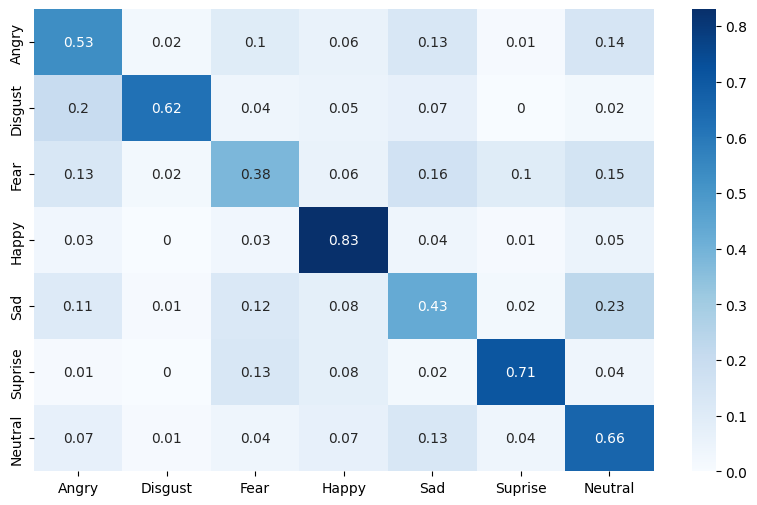

In [21]:
labels = test_dataset.label_encoder.inverse_transform(test_dataset.labels)
predictions = []
with torch.no_grad():
    for inputs, _ in test_dl: 
        predictions.extend(torch.argmax(net(inputs), dim=1).data.cpu().numpy())

cf_matrix = confusion_matrix(labels, predictions)

df_cm = pd.DataFrame(
    data = [row / np.sum(row) for row in cf_matrix],
    index = [i for i in classes.values()], 
    columns = [i for i in classes.values()]
).round(2)

plt.figure(figsize = (10,6))
sns.heatmap(df_cm, annot=True, cmap="Blues")